In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.fft import fft, ifft
#from scipy.fft import fft, ifft

We will now perform an DFT of $x[k]$ since we are interested in the frequency spectrum of it.

## DFT Definition

The discrete Fourier transform pair for a discrete-time signal $x[k]$ with sample index $k$ and the corresponding DFT spectrum $X[\mu]$ with frequency index $\mu$ is given as 
\begin{align}
\text{DFT}: X[\mu]=&\sum_{k=0}^{N-1}x[k]\cdot\mathrm{e}^{-\mathrm{j}\frac{2\pi}{N}k\mu}\\
\text{IDFT}: x[k]=\frac{1}{N}&\sum_{\mu=0}^{N-1}X[\mu]\cdot\mathrm{e}^{+\mathrm{j}\frac{2\pi}{N}k\mu}
\end{align}

Note the sign reversal in the exp()-function and the $1/N$ normalization in the IDFT. This convention is used by the majority of DSP text books and also in Python's `numpy.fft.fft()`, `numpy.fft.ifft()` and Matlab's `fft()`, `ifft()` routines.

## DFT and IDFT with For-Loops

We are now going to implement the DFT and IDFT with for-loop handling. While this might be helpful to validate  algorithms in its initial development phase, this should be avoided for practical used code in the field: for-loops are typically slow and very often more complicated to read than appropriate set up matrices and vectors. Especially for very large $N$ the computation time is very long.

Anyway, the for-loop concept is: the DFT can be implemented with an outer for loop iterating over $\mu$ and an inner for loop summing over all $k$ for a specific $\mu$.

We use variable with _ subscript here, in order to save nice variable names for the matrix based calculation.

In [5]:
# DFT with for-loop:
X_ = np.zeros((N, 1), dtype=complex)  # alloc RAM, init with zeros
for mu_ in range(N):  # do for all DFT frequency indices
    for k_ in range(N):  # do for all sample indices
        X_[mu_] += x[k_] * np.exp(-1j*2*np.pi/N*k_*mu_)

IDFT with outer and inner looping reads as follows.

In [6]:
# IDFT with for-loop:
x_ = np.zeros((N, 1), dtype=complex)  # alloc RAM, init with zeros
for k_ in range(N):
    for mu_ in range(N):
        x_[k_] += X_[mu_] * np.exp(+1j*2*np.pi/N*k_*mu_)
x_ *= 1/N  # normalization in the IDFT stage

Besides exchanged variables, main differences are sign reversal in exp() and the $1/N$ normalization. This is expected due to the DFT/IDFT equation pair given above.

## DFT and IDFT with Matrix Multiplication

Now we do a little better: We should think of the DFT/IDFT in terms of a matrix operation setting up a set of linear equations.

For that we define a column vector containing the samples of the discrete-time signal $x[k]$
\begin{equation}
\mathbf{x}_k = (x[k=0], x[k=1], x[k=2], \dots , x[k=N-1])^\mathrm{T}
\end{equation}

and a column vector containing the DFT coefficients $X[\mu]$

\begin{equation}
\mathbf{x}_\mu = (X[\mu=0], X[\mu=1], X[\mu=2], \dots, X[\mu=N-1])^\mathrm{T}
\end{equation}

Then, the matrix operations

\begin{align}
\text{DFT:   } & \mathbf{x}_\mu = \mathbf{W}^* \mathbf{x}_k\\
\text{IDFT:   } & \mathbf{x}_k = \frac{1}{N} \mathbf{W} \mathbf{x}_\mu
\end{align}

hold.

$()^\mathrm{T}$ is the transpose, $()^*$ is the conjugate complex.


The $N\times N$ Fourier matrix is defined as (element-wise operation $\odot$)
\begin{equation}
\mathbf{W} = \mathrm{e}^{+\mathrm{j}\frac{2\pi}{N} \odot \mathbf{K}}
\end{equation}
using the so called twiddle factor (note that the sign in the exp() is our convention)
\begin{equation}
W_N = \mathrm{e}^{+\mathrm{j}\frac{2\pi}{N}}
\end{equation}
and the outer product
\begin{equation}
\mathbf{K} = 
\begin{bmatrix}
0\\
1\\
2\\
\vdots\\
N-1
\end{bmatrix}
\cdot
\begin{bmatrix}
0 & 1 & 2 & \cdots & N-1
\end{bmatrix}
\end{equation}
containing all possible products $k\,\mu$ in a suitable arrangement.

For the simple case $N=4$ these matrices are
\begin{align}
\mathbf{K} = \begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 1 & 2 & 3\\
0 & 2 & 4 & 6\\
0 & 3 & 6 & 9
\end{bmatrix}
\rightarrow
\mathbf{W} = \begin{bmatrix}
1 & 1 & 1 & 1\\
1 & +\mathrm{j} & -1 & -\mathrm{j}\\
1 & -1 & 1 & -1\\
1 & -\mathrm{j} & -1 & +\mathrm{j}
\end{bmatrix}
\end{align}

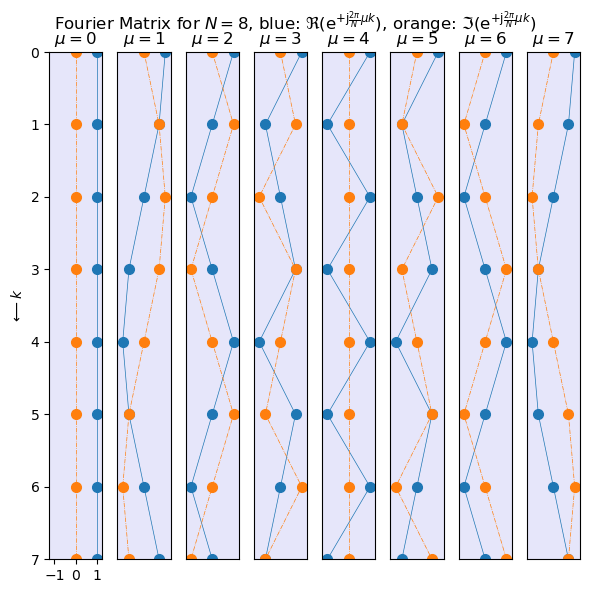

In [13]:
# visualize the content of the Fourier matrix
# we've already set up (use other N if desired):
# N = 8
# k = np.arange(N)
# mu = np.arange(N)
# W = np.exp(+1j*2*np.pi/N*np.outer(k, mu))  # set up Fourier matrix

fig, ax = plt.subplots(1, N)
fig.set_size_inches(6, 6)
fig.suptitle(
    r'Fourier Matrix for $N=$%d, blue: $\Re(\mathrm{e}^{+\mathrm{j} \frac{2\pi}{N} \mu k})$, orange: $\Im(\mathrm{e}^{+\mathrm{j} \frac{2\pi}{N} \mu k})$' % N)

for tmp in range(N):
    ax[tmp].set_facecolor('lavender')
    ax[tmp].plot(W[:, tmp].real, k, 'C0o-', ms=7, lw=0.5)
    ax[tmp].plot(W[:, tmp].imag, k, 'C1o-.', ms=7, lw=0.5)
    ax[tmp].set_ylim(N-1, 0)
    ax[tmp].set_xlim(-5/4, +5/4)
    if tmp == 0:
        ax[tmp].set_yticks(np.arange(0, N))
        ax[tmp].set_xticks(np.arange(-1, 1+1, 1))
        ax[tmp].set_ylabel(r'$\longleftarrow k$')
    else:
        ax[tmp].set_yticks([], minor=False)
        ax[tmp].set_xticks([], minor=False)
    ax[tmp].set_title(r'$\mu=$%d' % tmp)
fig.tight_layout()
fig.subplots_adjust(top=0.91)

fig.savefig('fourier_matrix.png', dpi=300)

# TBD: row version for analysis

## Fourier Matrix Properties

The DFT and IDFT basically solve two sets of linear equations, that are linked as forward and inverse problem.

This is revealed with the important property of the Fourier matrix

\begin{equation}
\mathbf{W}^{-1}
= \frac{\mathbf{W}^\mathrm{H}}{N}
= \frac{\mathbf{W}^\mathrm{*}}{N},
\end{equation}

the latter holds since the matrix is symmetric.

Thus, we see that by our convention, the DFT is the inverse problem (signal analysis) and the IDFT is the forward problem (signal synthesis)

\begin{align}
\text{DFT:   } & \mathbf{x}_\mu = \mathbf{W}^* \mathbf{x}_k \rightarrow \mathbf{x}_\mu = N \mathbf{W}^{-1} \, \mathbf{x}_k\\
\text{IDFT:   } & \mathbf{x}_k = \frac{1}{N} \mathbf{W} \mathbf{x}_\mu.
\end{align}

The occurrence of the $N$, $1/N$ factor is due to the prevailing convention in signal processing literature.

If the matrix is normalised as $\frac{\mathbf{W}}{\sqrt{N}}$, a so called unitary matrix results, for which the 
important property
\begin{equation}
(\frac{\mathbf{W}}{\sqrt{N}})^\mathrm{H} \, (\frac{\mathbf{W}}{\sqrt{N}}) = \mathbf{I} =
(\frac{\mathbf{W}}{\sqrt{N}})^{-1} \, (\frac{\mathbf{W}}{\sqrt{N}})
\end{equation}
holds, i.e. the complex-conjugate, transpose is equal to the inverse
$(\frac{\mathbf{W}}{\sqrt{N}})^\mathrm{H} = (\frac{\mathbf{W}}{\sqrt{N}})^{-1}$
and due to the matrix symmetry also
$(\frac{\mathbf{W}}{\sqrt{N}})^* =
(\frac{\mathbf{W}}{\sqrt{N}})^{-1}$
is valid.

This tells that the matrix $\frac{\mathbf{W}}{\sqrt{N}}$ is **orthonormal**, i.e. the matrix spans a orthonormal vector basis (the best what we can get in linear algebra world to work with) of $N$ normalized DFT eigensignals.

So, DFT and IDFT is transforming vectors into other vectors using the vector basis of the Fourier matrix.


Besides different quantization errors in range $10^{-15...-16}$ (which is prominent even with 64Bit double precision calculation)
all results produce the same output.

The analysis stage for the discrete-time signal domain, i.e. the DFT
can be reinvented by some intuition:
How 'much' of the reference signal $\mathbf{w}_{\text{column i}}$
(any column in $\mathbf{W}$)
is contained in the discrete-time signal $\mathbf{x}_k$ that is to be analysed.

In signal processing / statistic terms we look for the amount of correlation
of the signals
$\mathbf{w}_{\text{column i}}$ and $\mathbf{x}_k$.

In linear algebra terms we are interested in the projection of $\mathbf{x}_k$ onto
$\mathbf{w}_{\text{column i}}$, because the resulting length of this vector
reveals the amount of correlation, which is precisely one DFT coefficient $X[\cdot]$.

The complex inner products $\mathbf{w}_{\text{column i}}^\text{H} \cdot \mathbf{x}_k$
reveals these searched quantities.

In [15]:
if N == 8:
    print(np.conj(W[:, 0])@x_test)
    print(np.conj(W[:, 1])@x_test)
    print(np.conj(W[:, 2])@x_test)

(8+1.5795167060460874e-16j)
(1.9999999999999996-1.3877787807814462e-16j)
(4-2.346468407104653e-16j)


Doing this for all columns of matrix $\mathbf{W}$, all DFT coefficients are obtained, such as

\begin{align}
X[\mu=0] =& \mathbf{w}_{\text{column 1}}^\text{H} \cdot \mathbf{x}_k\\
X[\mu=1] =& \mathbf{w}_{\text{column 2}}^\text{H} \cdot \mathbf{x}_k\\
X[\mu=2] =& \mathbf{w}_{\text{column 3}}^\text{H} \cdot \mathbf{x}_k\\
X[\mu=3] =& \mathbf{w}_{\text{column 4}}^\text{H} \cdot \mathbf{x}_k\\
&\vdots\\
X[\mu=N-1] =& \mathbf{w}_{\text{column N}}^\text{H} \cdot \mathbf{x}_k.
\end{align}

Naturally, all operations can be merged to one single
matrix multiplication using the conjugate transpose of $\mathbf{W}$.

\begin{equation}
\mathbf{x}_\mu = \mathbf{W}^\text{H} \cdot \mathbf{x}_k = \mathbf{W}^* \cdot \mathbf{x}_k
\end{equation}

That's what we have performed with the single liner `X_test2 = np.matmul(np.conj(W), x_test)`

In [16]:
X = fft(x)

print(np.allclose(np.matmul(np.conj(W), x), X))

True


Next, let us plot the magnitude of the spectrum over $\mu$.

- We should play around with the variable `tmpmu` when defining the input signal at the very beginning of the notebook. For example we can check what happens for `tmpmu = 1`, `tmpmu = 2` and run the whole notebook to visualize the actual magnitude spectra.

We should recognize the link of the 'energy' at $\mu$ in the magnitude spectrum with the chosen `tmpmu`.

- We can apply any real valued `tmpmu` for creating the input signal, for example
    - `tmpmu = N+1`, `tmpmu = N+2`
    - `tmpmu = 1.5`
    
We should explain what happens in these cases. Recall periodicity and eigenfrequencies/-signals as fundamental concepts.

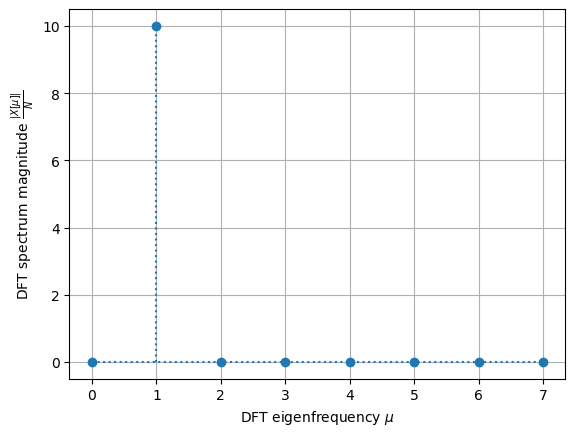

In [17]:
plt.stem(mu, np.abs(X)/N, markerfmt='C0o', basefmt='C0:', linefmt='C0:')
plt.xlabel(r'DFT eigenfrequency $\mu$')
plt.ylabel(r'DFT spectrum magnitude $\frac{|X[\mu]|}{N}$')
plt.grid(True)

**Copyright**

The notebooks are provided as [Open Educational Resources](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebooks for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Frank Schultz, Digital Signal Processing - A Tutorial Featuring Computational Examples* with the URL https://github.com/spatialaudio/digital-signal-processing-exercises

In [3]:
## own data

Do results match numpy's ifft?: False
DC is 1 as expected:  (0.6666666666666669-3.0839528461809903e-16j)
Matrix K:
 [[ 0  0  0  0  0  0  0  0  0]
 [ 0  1  2  3  4  5  6  7  8]
 [ 0  2  4  6  8 10 12 14 16]
 [ 0  3  6  9 12 15 18 21 24]
 [ 0  4  8 12 16 20 24 28 32]
 [ 0  5 10 15 20 25 30 35 40]
 [ 0  6 12 18 24 30 36 42 48]
 [ 0  7 14 21 28 35 42 49 56]
 [ 0  8 16 24 32 40 48 56 64]]

Matrix W:
 [[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.-1.j  0.-1.j -0.-1.j -1.-0.j -1.+0.j -1.+1.j  0.+1.j  1.+1.j]
 [ 1.+0.j  0.-1.j -1.-0.j -1.+1.j  1.+1.j  1.-1.j -0.-1.j -1.+0.j  0.+1.j]
 [ 1.+0.j -0.-1.j -1.+1.j  1.+0.j -0.-1.j -1.+1.j  1.+0.j -0.-1.j -1.+1.j]
 [ 1.+0.j -1.-0.j  1.+1.j -0.-1.j  0.+1.j  0.-1.j -1.+1.j  1.-1.j -1.+0.j]
 [ 1.+0.j -1.+0.j  1.-1.j -1.+1.j  0.-1.j  0.+1.j -0.-1.j  1.+1.j -1.-0.j]
 [ 1.+0.j -1.+1.j -0.-1.j  1.+0.j -1.+1.j -0.-1.j  1.+0.j -1.+1.j -0.-1.j]
 [ 1.+0.j  0.+1.j -1.+0.j -0.-1.j  1.-1.j  1.+1.j -1.+1.j -1.-0.j  0.-1.j]
 

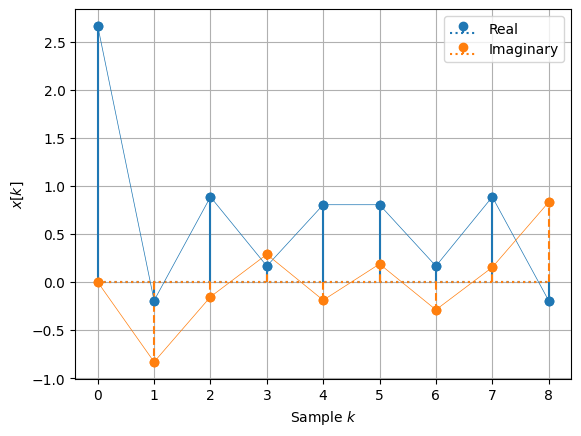

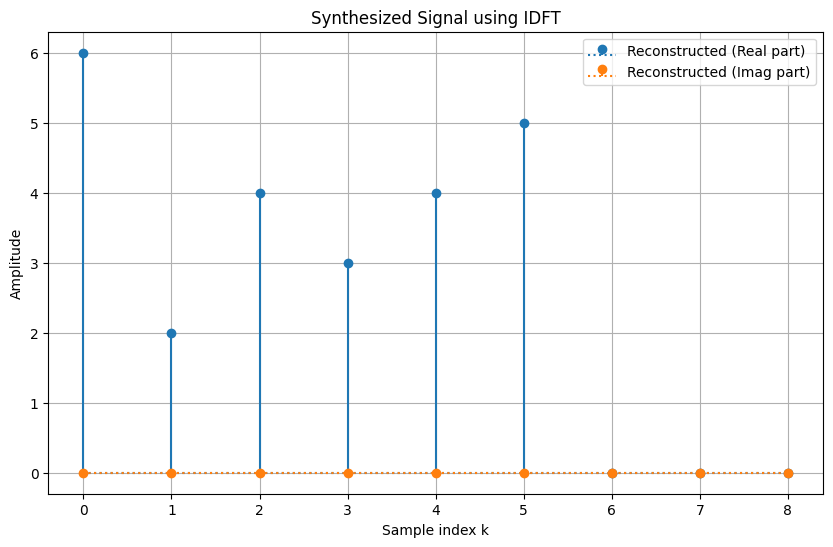

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import ifft

# Define the signal
x_mu = np.array([6, 2, 4, 3, 4, 5, 0, 0, 0], dtype=float)
N = len(x_mu)

# Create the index matrix K
k = np.arange(N)
mu = np.arange(N)
K = np.outer(k, mu)  # Compute K matrix

# Construct the Fourier matrix W for DFT
W = np.exp(-2j * np.pi * K / N)

# Compute DFT using the W matrix
X = np.dot(W, x_mu)

# Replace the example with your data
if N == 9:
    X_test = np.array([6, 2, 4, 3, 4, 5, 0, 0, 0])  # Your data
    x_test = 1 / N * np.matmul(W, X_test)

    # Plot the real and imaginary parts
    plt.stem(k, np.real(x_test), label='Real',
             markerfmt='C0o', basefmt='C0:', linefmt='C0-')
    plt.stem(k, np.imag(x_test), label='Imaginary',
             markerfmt='C1o', basefmt='C1:', linefmt='C1--')
    # Connecting samples with lines for visual convenience
    plt.plot(k, np.real(x_test), 'C0o-', lw=0.5)
    plt.plot(k, np.imag(x_test), 'C1o-', lw=0.5)
    plt.xlabel(r'Sample $k$')
    plt.ylabel(r'$x[k]$')
    plt.legend()
    plt.grid(True)

    # Check if results match numpy's ifft
    print("Do results match numpy's ifft?:", np.allclose(ifft(X_test), x_test))
    print('DC is 1 as expected: ', np.mean(x_test))

# Construct the inverse Fourier matrix W_inv for IDFT
W_inv = np.exp(2j * np.pi * K / N)

# Reconstruct the signal using IDFT
x_reconstructed = (1 / N) * np.dot(W_inv, X)

# Display the matrices K and W
print("Matrix K:\n", K)
print("\nMatrix W:\n", W.round(0))

# Display the reconstructed signal
print("\nReconstructed signal x (IDFT):\n", x_reconstructed)

# Plot the synthesized signal (real and imaginary parts)
plt.figure(figsize=(10, 6))
plt.stem(k, np.real(x_reconstructed), markerfmt='C0o', basefmt='C0:', linefmt='C0-', label='Reconstructed (Real part)')
plt.stem(k, np.imag(x_reconstructed), markerfmt='C1o', basefmt='C1:', linefmt='C1--', label='Reconstructed (Imag part)')
plt.title("Synthesized Signal using IDFT")
plt.xlabel("Sample index k")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()
